# Week 11: Networks 3 (epidemiology)


While researchers have been modeling the spread of diseases and information for many years, the COVID-19 pandemic playing out right now puts a new emphasis on the importance of being able to model (and thus predict) how diseases propagate through populations. So how do you most effectively model the spread of a disease? There are many^ ways, and all of them (at least the useful ones) involves networks. In this notebook you will get your hands on a couple different modeling approaches. Specifically:

* Spreading processes on static networks
* Spreading processes on temporal networks
* Metapopulation models

**Questions**: Outside of class, use [issue on GitHub](https://github.com/abjer/tsds/issues) for asking questions.

## Imports

In [1]:
%matplotlib inline
import matplotlib.pylab as plt
import networkx as nx
import netwulf as nw
import numpy as np
import pandas as pd

## Exercises

In a *contact network* nodes are people and links represent interactions that can happen between people. You can use such a network as a *substrate* for simulating the spreading of "something". Spreading of what? That's up to you. It can be a disease, a behavior, a piece of information, anything you can imagine people may pass along. There's a whole subfield of Network Science which deals with this, but the fundamental idea is actually quite simple:

> Nodes that are connected can transmit this "something" with a probability. Each timestep of the simulation is an opportunity for the "something" to spread.

You can then make this more nuanced by adding extra criteria for transmission. For disease modeling these can e.g. be that nodes can only be infected after multiple exposures or if multiple neighbors are infected, that they can be cured and become resistant/susceptible with some probability, that they may die and exit the simulation creating a void in the network, that becoming infected makes them change their links, that godzilla walks in and eats everyone—the possibilities are endless and you decide which rules exist in the simulation universe.

Generally speaking, there are four major classes of so-called "compartmental models" in network epidemiology:
* *Susceptible-Infected (SI)*: Nodes are susceptible at start, and once they are infected they never recover. This models spreading of unforgetable information, or diseases that people get and pass on, and never recover from (like HIV, herpes, etc.).
* *Susceptible-Infected-Susceptible (SIS)*: Nodes are susceptible, then get infected and stay infected for some time, then get susceptible again, and the cycle continues. This could model things like the flu which comes and goes and you get and recover from over and over again.
* *Susceptible-Infected-Resistant (SIR)*: Nodes become infected and after some time they gain resistance so that they can neither become infected nor spread disease/information further. Once they are resistant they are essentially "removed" from the network, so this type of model works for diseases where people recover and gain resistance as well as ones that kill people, as niether type of person can transmit (measles, chickenpox but also rabies, Creutzfeldt–Jakob disease, etc.).
* *Susceptible-Infected-Resistant-Susceptible (SIRS)*: Probably self-explanatory if you understood the above.

The idea that drives the "compartmental" modelling approach is that within a population you can assign each
individual to a compartment based on their "state" (infected, susceptible, etc.). When you start the simulation,
individuals then flow between compartments with specific flow rates.

![img](https://upload.wikimedia.org/wikipedia/commons/9/93/SIR_Flow_Diagram.svg)

This then allows us to describe the flow of individuals between compartments (and thus the spreading of the disease)
using differential equations. For example in the simple SIR model shown above, the dynamics can be described with
three differential equations (one for each compartment). They each tell us how fast the population in the corresponding
compartment is changing:

$$\frac{dS}{dt} = -\beta SI$$

$$\frac{dI}{dt} = \beta SI - \gamma I$$

$$\frac{dR}{dt} = \gamma I$$

So at a given point in time how many people are leaving the susceptible compartment and entering the infected compartment?
Well that's simply the number of susceptible $S$ times the number of infected $I$ multipled with some disease-specific constant $\beta$.

And what's the growth in the number of infected? Easy! It's just the number of people coming in from the susceptible compartment $\beta SI$ minus all the people leaving for the "Recovered" compartment $\gamma I$, where gamma is some constant that describs how fast people recover.

And the rate at which people enter the recovered state? If you understood the above you can explain this to yourself.

**That's it!** That's how all compartmental models work!

> **Ex. 11.1.1**: But as I wrote above there are many different types of compartmental models. Write down the rate equations for the SIS model:
>
>![img](https://upload.wikimedia.org/wikipedia/commons/c/cb/SIS_compartment_model.svg)
>
> Follow the reasoning in the example for the SIR model above. Answer the following:
* How many equations do you need if there are two compartments?
* What specifically does each equation describe?
* What do $\beta$ and $\gamma$ intuitively describe? What can you say about a disease with a really big $\gamma$? Or a really small $\gamma$? How about big or small $\beta$?

**Answer:**

I am not completely sure if "rate equations" are the equations descrbing how the flow of individuals between compartments or the equation describing the growth in the number of infected over time. But the flow of individuals between compartments can be described with two equations, one for each compartment:

$$
\begin{aligned}
&\frac{dS(t)}{dt} = -\beta S I + \gamma I \\
&\frac{dI(t)}{dt} = \beta S I - \gamma I,
\end{aligned}
$$

where I guess that the population size is normalised to 1 in the above equations, so I did it as well.


The first equation describe the flow of individuals in and out of the susceptible compartment, and the second equation describes the flow of individuals in and out of the infected compartment. $S I$ is the number of susceptible individuals that have an encounter with an infected individual in one time period (under the assumption of homogeneous mixing and a population size of 1). $\beta$ is the likelihood that the disease/information/whatevs will be transmitted from an infected to a susceptible individual in a time period. Hence, $\beta S I$ is the number of individuals that moves from the susceptible compartment to the infected compartment. $\gamma I$ is the number of infected individuals that recover in each time period, i.e. move from the infected compartment to the susceptible compartment. 


$\beta$ is the likelihood that the disease/information/whatevs will be transmitted from an infected to a susceptible individual in a time period, and $\gamma$ is the recovery rate of infected individuals, i.e. the share of infected individuals that recovers in each time period. A disease that has a really high $\gamma$ is easy to recover from, and a disease with a low $\gamma$ is really hard to recover from. An example of a disease with high $\gamma$ is the flu, where infected people usually recover in a week or two. A disease with a large $\beta$ is easily transmitted, which COVID-19 is a great example of. A disease with a low $\beta$ is not very easily transmitted. 

> **Ex. 11.1.2** (optional): If you really understood the above, you should have no trouble writing down the equations for a SIRS
model. Go ahead and try. Hint: You will need to introduce a new constant that describes the rate at which people move from R to S.

**Answer:**

In the SIRS model, there are three differential equations - one for each compartment, describing the flow in and out of the compartment:

$$
\begin{align}
&\frac{dS}{dt} = \mu R - \beta SI \\
&\frac{dI}{dt} = \beta SI - \gamma I \\
&\frac{dR}{dt} = \gamma I - \mu R,
\end{align}
$$

where $\mu$ is the rate at which recovered individuals return to being susceptible. 

> **Ex. 11.1.3**: Professor of physics and mathematic and all around cool guy, Dirk Brockmann,
makes interactive articles called *Explorables* that introduce ideas in Complexity science. Read/play with
[his explorable](http://www.complexity-explorables.org/explorables/neighbors/) on targeted vaccination to mitigate epidemic spreading in the real world and answer the
following questions:
> 1. In the BA network, roughly what percentage of the population do you have to vaccinate with **strategy A** to only get around 10
infected individuals? What about **startegy B** and **strategy C**?
> 2. **strategy A** and **strategy C** are both entirely random, but one is much more effective than the other. Explain
why. What clever idea is **strategy C** employing?
> 3. Why is this effect larger in the BA network than in the ER network?

**Answer:**

1. The percentage of the population needed vaccinated to only get around 10 infected individuals:
 - Strategy A: Around 78% (I assume that the read individuals are infected and the grey are not)
 - Strategy B: Around 13%
 - Strategy C: Around 50%
 
 
2. Strategy C exploits the idea of the so-called *friendship paradox* stating that the on average, the neighbours to a node have a higher degree than the node itself. So in strategy C, a group of individuals are chosen randomly and then for each individual, a link is chosen randomly. The nodes, that these links are connecting to, are vaccinated. By using this vaccination strategy, hubs with many links are vaccinated, which alters the underlying contact network, making it harder for the virus to spread. 


3. An Erdős–Rényi (ER) network is a random network. A Barbási-Albert (BA) network is also random and starts with $m_0$ nodes that have random links (minimum one each). Then, the network develops as one node with $m$ links is added at each timestep, such that it's attached to $m$ nodes already in the network. The probability of generating a link to an already existing node is positively related to the degree of that node. To sum up, the ER network is random and the BA network is scale-free. The variance of the scale-free network is much larger than in the random network, and in large scale-free networks, the so-called *epidemic threshold* is vanishing, which means that even viruses with small spreading rates can persist in the network. 

> **Ex. 11.1.4**: Choose one of these two explorables ([1](http://www.complexity-explorables.org/explorables/herd/) or [2](http://www.complexity-explorables.org/explorables/epidemonic/)) read/play with and understand it, and explain in your own words what phenomenon it communicates.

**Answer:**

I chose the explorable on *herd immunity*. The phenomenon of *herd immunity* is when a virus is eradicated from a population, even though it is only a fraction of the individuals that is immunized. 


The model is an SIS model, i.e. individuals are susceptible to a pathogen and can get infected by being in contact with an infected individual. After some time, they become susceptible again. Then, vaccination is introduced - after an individual is vaccinated, they become immune to the pathogen, which means that they can't get infected and they can't infect others. The explorable shows how herd immunity is created in a population, when the network is described by different model. You can control the transmitability of the pathogen and the vaccination rate and see how these factors affect the timing of herd immunity. 

> **Ex. 11.1.5**: The simplest compartmental model is the *SI* model. Below I have implemented a simulation of such a model.
You can see in line 5 that I initialize all nodes in the *S* compartment, but after running, all nodes are in the *I* compartment.
Does this make sense to you?
1. Comment the code abundantly, explaining what's happing at each step.
2. Adapt the code and make a plot of the fraction of infected over time. You may have to restart it a couple of times to make sure patient 0 is someone connected to the rest of the population.
3. Extend the code such after a variable number of timesteps `T_I` infected nodes become susceptible again. Set `T_I = 10` to begin with and plot the fraction of infected over time for 200 timesteps. Does the result make sense? Comment on what you see.

**Answer:**

It does make sense that all individuals are infected after 200 iterations, since each infected node on average infects 10 percent of the nodes it has a link to, and the network consists of 10 cliques connected to each other. 

**Answer to 11.1.5.1 and 11.1.5.2:**

In [13]:
# a. Initialising a connected caveman network with 10 cliques of 5 nodes
G = nx.connected_caveman_graph(10, 5)
# _ = nw.visualize(G) # Uncomment if you want to have a look at the network

In [14]:
# b. Setting transmissibility and number of iterations in simulation 
p_I = 0.1
n_iter = 200
N = len(G.nodes())

# c. Creating population with only susceptible individuals
I = set() # Initilising empty set for infected individuals
S = set(G.nodes())
frac_I = []
T = []

# d. Choosing a random node to be patient zero
patient0 = np.random.choice(list(S))

# e. Add patient zero to the set of infected individuals and removing it from the susceptibles
I.add(patient0)
S.remove(patient0)

# f. Simulate: Loop over the number of iterations
for t in range(n_iter):
    
    # i. Looping over each infected node in the network
    for infected_node in list(I):
        
        # ii. Identify the neighbours of the infected node
        neighbors = G.neighbors(infected_node)
        
        # iii. Infect a random fraction p_I of the neighbours
        infected_neighbors = set([n for n in neighbors if np.random.random() < p_I])
        
        # iv. Add the newly infected neighbours to the set of infected and remove from susceptibles
        I |= infected_neighbors
        S -= infected_neighbors
        
    # v. Calculate the fraction of infected
    frac = len(I)/N
    frac_I.append(frac)
    T.append(t)

In [15]:
# g. Print number of infected and susceptible
print(f'After {n_iter} periods/iterations with a transmissibility of {p_I}, there are: \n' 
      f'{len(S)} susceptible individuals and {len(I)} infected individuals')

After 200 periods/iterations with a transmissibility of 0.1, there are: 
0 susceptible individuals and 50 infected individuals


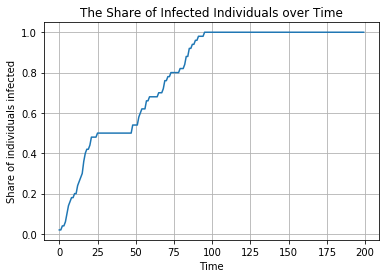

In [16]:
# f. Plot the share of infected individuals over time
plt.plot(T, frac_I)
plt.title('The Share of Infected Individuals over Time')
plt.xlabel('Time')
plt.ylabel('Share of individuals infected')
plt.grid()

**Answer to 11.1.5.3:**

The share of infected individuals never reaches 100 percent now. This makes sense, since people now can recover from the infection and become susceptible again. But it seems like the share of infected reaches some sort of equilibrium, where it fluctuates between 50 percent and 90 percent of the population. 

In [17]:
# b. Setting transmissibility and number of iterations in simulation 
p_I = 0.1
n_iter = 200
N = len(G.nodes())
T_I = 10

# c. Creating population with only susceptible individuals
I = set() # Initialising empty set for infected individuals
S = set(G.nodes())
frac_I = [] 
T = []
inf_time = np.zeros(N)

# d. Choosing a random node to be patient zero
patient0 = np.random.choice(list(S))

# e. Generate a dictionary with the all individuals in the network, the period they've been infected, and their compartment
pop_dict = {i: (0, 'S') for i in G}

# f. Add patient zero to the set of infected individuals and removing it from the susceptibles
I.add(patient0)
S.remove(patient0)
pop_dict[patient0] = (0,'I')

# g. Simulate: Loop over the number of iterations
for t in range(n_iter):
    
    # Add 1 to all periods in dictionary
    pop_dict = {i: (t+1,c) for i,(t,c) in pop_dict.items()}
    
    # Copy dictionary to loop over (can't loop over a dictionary that's changing)
    dict_loop = pop_dict.copy()
    
    # Looping over each infected node in the network
    for i, (inf_time, c) in dict_loop.items():
        
        # When the individual has been infected for less than T_I periods
        if inf_time < T_I and c == 'I':
            
            # Identify the neighbours of the infected node who are not already infected
            neighbors = [s for s in G.neighbors(i) if pop_dict[s][1] == 'S']

            # Infect a random fraction p_I of the neighbours
            infected_neighbors = set([n for n in neighbors if np.random.random() < p_I])

            # Add the newly infected neighbours to the set of infected and remove from susceptibles
            I |= infected_neighbors
            S -= infected_neighbors
            
            for inf in infected_neighbors:
                pop_dict[inf] = (0, 'I')
        
        # When the individual has been infected for T_I periods
        elif inf_time == T_I and c == 'I':
            
            # Remove the individual from the infected and add to susceptible
            I.remove(i)
            S.add(i)
            pop_dict[i] = (0, 'S')
    
    # v. Calculate the fraction of infected
    frac = len(I)/50
    frac_I.append(frac)
    T.append(t)

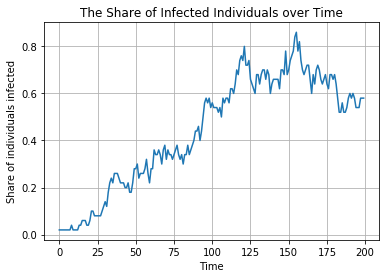

In [18]:
# h. Plot the share of infected individuals over time
plt.plot(T, frac_I)
plt.title('The Share of Infected Individuals over Time')
plt.xlabel('Time')
plt.ylabel('Share of individuals infected')
plt.grid()

> **Ex. 11.1.6**: Use what you have learned and implement an SIRS model.
* Run it on the Facebook network from last week (so load that into a `networkx.Graph`).
* Record the fraction of infected, susceptiple and recovered over time.
* After the simulation has run, plot these quantities over time and comment on your results
* Be proud of yourself for having solved a really interesting problem.

**Answer:**

I find that the compartments in the Facebook network have very cyclical behaviour, and seem like converging to a equilibrium. 

In [19]:
# a. Load the Facebook network
data = pd.read_csv(
    "facebook-wall.txt.gz",
    delimiter="\t",
    header=None,
    names=['user1', 'user2', 'timestamp'])

G = nx.from_pandas_edgelist(data, 'user1', 'user2', create_using=nx.Graph)

In [29]:
# b. Setting transmissibility and number of iterations in simulation 
p_I = 0.1
n_iter = 200
N = len(G.nodes())
T_I = 10
T_R = 10

# c. Creating population with only susceptible individuals
I = set() # Initialising empty set for infected individuals
R = set() # Initialising empty set for recovered individuals
S = set(G.nodes())
frac_I = [] 
frac_S = []
frac_R = []
T = []

# d. Choosing a random node to be patient zero
patient0 = np.random.choice(list(S))

# e. Generate a dictionary with the all individuals, the period they've been infected and recovered, and their compartment
pop_dict = {i: (0, 'S') for i in G}

# f. Add patient zero to the set of infected individuals and removing it from the susceptibles
I.add(patient0)
S.remove(patient0)
pop_dict[patient0] = (0, 'I')

# g. Simulate: Loop over the number of iterations
for t in range(n_iter):
    
    # Calculate the fraction of infected
    frac_I.append(len(I)/N)
    frac_S.append(len(S)/N)
    frac_R.append(len(R)/N)
    T.append(t)
    
    # Add 1 to all periods in dictionary
    pop_dict = {i: (t+1,c) for i,(t,c) in pop_dict.items()}
    
    # Copy dictionary to loop over (can't loop over a dictionary that's changing)
    dict_loop = pop_dict.copy()
    
    # Looping over each infected node in the network
    for i, (t,c) in dict_loop.items():
        
        # When the individual has been infected for less than T_I periods
        if t < T_I and c == 'I':
            
            # Identify the neighbours of the infected node who are not recovered (and thus cannot be infected)
            neighbors = [s for s in G.neighbors(i) if pop_dict[s][1] == 'S']

            # Infect a random fraction p_I of the neighbours
            infected_neighbors = set([n for n in neighbors if np.random.random() < p_I])

            # Add the newly infected neighbours to the set of infected and remove from susceptibles
            I |= infected_neighbors
            S -= infected_neighbors
            
            for inf in infected_neighbors:
                pop_dict[inf] = (0, 'I')
        
        # When the individual has been infected for T_I periods
        elif t == T_I and c == 'I':
            
            # Remove the individual from the infected and add to recovered
            I.remove(i)
            R.add(i)
            pop_dict[i] = (0, 'R')
            
        # When the indivudual has been recovered for T_R period
        elif t == T_R and c == 'R':
            
            # Remove the individual from recovered and add to susceptible
            R.remove(i)
            S.add(i)
            pop_dict[i] = (0, 'S')

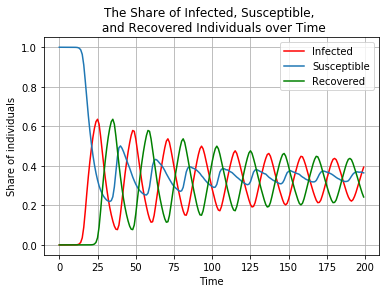

In [30]:
# h. Plot the share of infected individuals over time
plt.plot(T, frac_I, c='r')
plt.plot(T, frac_S)
plt.plot(T, frac_R, c='g')
plt.legend(['Infected', 'Susceptible', 'Recovered'])
plt.title('The Share of Infected, Susceptible, \n and Recovered Individuals over Time')
plt.xlabel('Time')
plt.ylabel('Share of individuals')
plt.grid()

### Further learning

Since the above exercises teaches you how to write down epidemic models (as systems of differential equations)
and subsequently teaches you how to simulate a spreading process on a network to obtain data on infected/susceptible/recovered
over time, you would think it natural that I also taught you how to fit these epidemic models to such data.
This, however, is going a bit too far as this is not a course in computational epidemiology. But if you want to
figure out how to do it, you literally just need to Google search for "fit SIR model".

And finally, a note on how these models are used in the real world. The state-of-the-art in epidemiological modeling is something called "meta popultion models". They are essentially systems of compartmental models. One component in such a model may be a country, and it has its own little SI, SIR or SIRS model. Components are then coupled because there are people moving between them. The paper *The Hidden Geometry of Complex,
Network-Driven Contagion Phenomena* by Dirk Brockmann and Dirk Helbing published in Science in 2013 ([link here](https://www.dropbox.com/s/hxprfyr51fwh907/brockmann13.pdf?dl=0)) sets up such a model for the world using airline traffic as a proxy for people flow between countries. It is a must read if you
are curious about how the pros predict things like when a disease will arrive in a certain place or where a disease originated. I strongly recommend reading it and understanding the figures, it is a stroke of genius.